In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
from environs import Env
env = Env()
env.read_env()
api_key=env("BITMEX_API_KEY")
api_secret=env("BITMEX_API_SECRET")

In [4]:
# Setup matplotlib to display graphs inline in this Notebook
%matplotlib inline

In [5]:
import bitmex
import math
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from scipy.signal import argrelextrema
from utils import get_klines_df, get_instrument
pd.set_option('display.width', 200)

/home/chekitsch/miniconda3/lib/python3.7/site-packages/swagger_spec_validator/validator20.py:53: SwaggerValidationWarning: Found "$ref: #/definitions/UserPreferences" with siblings that will be overwritten. See https://stackoverflow.com/a/48114924 for more information. (path #/definitions/User/properties/preferences)
  ref_dict['$ref'], '/'.join(path),


In [6]:
def turtle_soup(symbol, binSize, startDate, HOLDING_PERIOD, LOOKBACK_PERIOD = 120, SLIPPAGE_TICKS = 4, STOP_LOSS_PCT_FLOOR=0.0015):
    '''
    symbol 'XBTUSD' 'ETHUSD'
    binSize ['1H', '2H', '4H'] etc... 
    startDate '2019-05-01'
    HOLDING_PERIOD
    LOOKBACK_PERIOD: for finding previous breakouts
    SLIPPAGE_TICKS
    '''
    
    data_df = get_klines_df(symbol, '1h', startDate)
    data_df = data_df.drop(columns=['homeNotional','foreignNotional','turnover','vwap','lastSize'])
    data_df = data_df.drop([0], axis=0)    # drop first row, otherwise resample will not work properly
    data_df.index = data_df.timestamp     # change RangeIndex to TimestampIndex
    
    tickSize = get_instrument(symbol)['tickSize']
    SLIPPAGE = SLIPPAGE_TICKS * tickSize
    TAKER_FEE = 0.00075
    BREAKOUT_X_PERIOD = 19
    
    # resample to X-hour candle
    TD_binSize = timedelta(hours = int(binSize[:-1]))
    data_df = data_df.resample(binSize, closed='right').apply({'symbol':'first', 'open':'first', 'high':'max', 'low':'min', 'close':'last', 'trades':'sum', 'volume':'sum'})
    
    data_df['period_high_slow'] = data_df['high'].rolling(BREAKOUT_X_PERIOD, min_periods=4).max().shift(1)
    data_df['period_high_fast'] = data_df['high'].rolling(3, min_periods=3).max().shift(1)

    data_df['period_low_slow'] = data_df['low'].rolling(BREAKOUT_X_PERIOD, min_periods=4).min().shift(1)
    data_df['period_low_fast'] = data_df['low'].rolling(3, min_periods=3).min().shift(1)
    
    # assign new columns based on conditions
    data_df.loc[data_df.high > data_df.period_high_slow, 'isNewHigh'] = True
    data_df.loc[data_df.high <= data_df.period_high_slow, 'isNewHigh'] = False

    data_df.loc[data_df.low < data_df.period_low_slow, 'isNewLow'] = True
    data_df.loc[data_df.low >= data_df.period_low_slow, 'isNewLow'] = False
    
    
    # find all local peaks and troughs
    n=4
    data_df['trough'] = data_df.iloc[argrelextrema(data_df.low.values, np.less_equal, order=n)[0]]['low']
    data_df['peak'] = data_df.iloc[argrelextrema(data_df.high.values, np.greater_equal, order=n)[0]]['high']

    # *****************************************
    #  generate transactions table (dataframe)
    # *****************************************
    i = 0
    order_table = dict()    # symbol as key, include 'timestamp', side', 'stop_price' and 'stop_loss'
    tx_df = pd.DataFrame(columns=['timestamp', 'side', 'entry_price', 'stop_loss'])

    for timestamp, row in data_df.iterrows():
        index = (timestamp - data_df.index[0]) / TD_binSize
        if index < LOOKBACK_PERIOD:
            continue
        start = timestamp - (LOOKBACK_PERIOD * TD_binSize)
        end = timestamp - (1 * TD_binSize)
        current_window = data_df.loc[start:end]    # exclude current value

        isNewLow_index = current_window[(current_window.isNewLow == True) & (current_window.trough > 0)].index
        local_troughs = current_window.low.loc[isNewLow_index]

        isNewHigh_index = current_window[(current_window.isNewHigh == True) & (current_window.peak > 0)].index
        local_peaks = current_window.high.loc[isNewHigh_index]
        # print('{timestamp} low: {low:6.2f}\thigh: {high:6.2f}\tclose: {close:6.2f}\t4-day high: {period_high_fast:6.2f}\n'.format(
        #    timestamp=timestamp, low=row.low, high=row.high, close=row.close, period_high_fast=row.period_high_fast
        # ))

        if len(local_troughs) > 0:
            for idx in local_troughs.index:
                window = local_troughs[idx:local_troughs.index[len(local_troughs)-1]]
                abs_min = window.min()
                abs_min_idx = window.idxmin()
                # if not lowest trough and occurs prior to lowest trough, ignore it
                if window[idx] > abs_min and idx < abs_min_idx:
                    continue
                elif row.low < row.period_low_slow and row.period_low_fast > window[idx]:
                    # make sure is 20-day low, AND previous low is at least 4 days earlier
                    if row.low < window[idx] and row.close > window[idx]:
                        # BUY outright - price penetrated previous low but has closed above it
                        print('buy @ {entry_price:6.2f} stop-loss {stop_loss:6.2f}'.format(entry_price=window[idx], stop_loss=row.low))
                        entry_price = round((window[idx] + SLIPPAGE) * (1 + TAKER_FEE),1)
                        tx_df.loc[len(tx_df)] = [timestamp, 'BUY', entry_price, row.low]
                        if symbol in order_table:
                            del order_table[symbol]    # remove stop order
                        break
                    if row.low < window[idx] and row.close < window[idx] and symbol not in order_table:
                        # BUY NEXT PERIOD - price penetrated previous low and closed below
                        print('stop buy @ {entry_price:6.2f} stop-loss {stop_loss:6.2f}'.format(entry_price=window[idx], stop_loss=row.low))
                        order_table[symbol] = {'timestamp':timestamp, 'side':'BUY', 'stop_price':window[idx], 'stop_loss':row.low}
                        break

        if len(local_peaks) > 0:
            for idx in local_peaks.index:
                window = local_peaks[idx:local_peaks.index[len(local_peaks)-1]]
                abs_max = window.max()
                abs_max_idx = window.idxmax()
                # if not highest peak and occurs prior to highest peak, ignore it
                if window[idx] < abs_max and idx < abs_max_idx:
                    continue
                elif row.high > row.period_high_slow and row.period_high_fast < window[idx]:
                    # make sure is 20-day high, AND previous high is at least 4 days earlier
                    if row.high > window[idx] and row.close < window[idx]:
                        # SELL outright - price penetrated previous high but has closed below it
                        print('sell @ {entry_price:6.2f} stop-loss {stop_loss:6.2f}'.format(entry_price=window[idx], stop_loss=row.high))
                        entry_price = round((window[idx] - SLIPPAGE) * (1 - TAKER_FEE),1)
                        tx_df.loc[len(tx_df)] = [timestamp, 'SELL', entry_price, row.high]
                        if symbol in order_table:
                            del order_table[symbol]    # remove stop order
                        break
                    if row.high > window[idx] and row.close > window[idx] and symbol not in order_table:
                        # SELL NEXT PERIOD - price penetrated previous high and closed above
                        print('stop sell @ {entry_price:6.2f} stop-loss {stop_loss:6.2f}'.format(entry_price=window[idx], stop_loss=row.high))
                        order_table[symbol] = {'timestamp':timestamp, 'side':'SELL', 'stop_price':window[idx], 'stop_loss':row.high}
                        break
                        
        # if symbol has pending stop order from previous period (make sure is timestamp "plus one")
        if symbol in order_table and timestamp > order_table[symbol]['timestamp']:
            stop_price = order_table[symbol]['stop_price']
            if order_table[symbol]['side'] == 'BUY' and row.high > order_table[symbol]['stop_price']:
                stop_loss = min(order_table[symbol]['stop_loss'], row.low)
                entry_price = round((stop_price + SLIPPAGE) * (1 + TAKER_FEE),1)
                print('triggered stop buy @ {entry_price:6.2f} stop-loss {stop_loss:6.2f}'.format(entry_price=stop_price, stop_loss=stop_loss))
                tx_df.loc[len(tx_df)] = [timestamp, 'BUY', entry_price, stop_loss]

            if order_table[symbol]['side'] == 'SELL' and row.low < order_table[symbol]['stop_price']:
                stop_loss = max(order_table[symbol]['stop_loss'], row.high)
                entry_price = round((stop_price - SLIPPAGE) * (1 - TAKER_FEE),1)
                print('triggered stop sell @ {entry_price:6.2f} stop-loss {stop_loss:6.2f}'.format(entry_price=stop_price, stop_loss=stop_loss))
                tx_df.loc[len(tx_df)] = [timestamp, 'SELL', entry_price, stop_loss]
            # trigger or no trigger, delete from list no matter what
            del order_table[symbol]

    # set timestamp as transaction dataframe index
    tx_df.set_index('timestamp', drop=True, inplace=True)
    
    
    # **********************************************
    #  enhance transaction table data ()
    # **********************************************
    # calculate stop_loss percent
    tx_df = tx_df[~tx_df.index.duplicated()]
    tx_df.loc[tx_df.side == 'BUY', 'stop_loss_pct'] = (tx_df.stop_loss / tx_df.entry_price) - 1
    tx_df.loc[tx_df.side == 'SELL', 'stop_loss_pct'] = -((tx_df.stop_loss / tx_df.entry_price) - 1)

    high_water_mark = None    # lowest observed price for SELL, highest for BUY
    low_water_mark = None    # highest observed price for SELL, lowest for BUY
    stop_loss_triggered = False

    for i,txn in tx_df.iterrows():
        
        # adjust stop losses if below STOP_LOSS_PCT_FLOOR
        if abs(txn.stop_loss_pct) < STOP_LOSS_PCT_FLOOR:
            if txn.side == 'BUY':
                stop_loss_adj = txn.entry_price * (1-STOP_LOSS_PCT_FLOOR)
                tx_df.loc[i, 'stop_loss'] = math.floor(stop_loss_adj/tickSize) * tickSize
                tx_df.loc[i, 'stop_loss_pct'] = (stop_loss_adj / txn.entry_price) - 1
            if txn.side == 'SELL':
                stop_loss_adj = txn.entry_price * (1+STOP_LOSS_PCT_FLOOR)
                tx_df.loc[i, 'stop_loss'] = math.ceil(stop_loss_adj/tickSize) * tickSize
                tx_df.loc[i, 'stop_loss_pct'] = -((stop_loss_adj / txn.entry_price) - 1)
            
        trade_window = data_df.loc[i + TD_binSize : i + (TD_binSize * HOLDING_PERIOD)]
        for j,window in trade_window.iterrows():
            if txn.side == 'BUY' and window.low < txn.stop_loss and not stop_loss_triggered:
                # BUY stoploss triggered
                if high_water_mark is None: high_water_mark = window.high
                low_water_mark = txn.stop_loss
                stop_loss_triggered = True
                break
            if txn.side == 'SELL' and window.high > txn.stop_loss and not stop_loss_triggered:
                # SELL stoploss triggered
                if low_water_mark is None: low_water_mark = window.low
                high_water_mark = txn.stop_loss
                stop_loss_triggered = True
                break
            if high_water_mark is None or window.high > high_water_mark:
                # if not yet stopped out, update high water mark as appropriate
                high_water_mark = window.high
            if low_water_mark is None or window.low < low_water_mark:
                # if not yet stopped out, update low water mark as appropriate
                low_water_mark = window.low

        if txn.side == 'BUY':
            max_abs_return = ((high_water_mark/txn.entry_price) - 1)
            min_abs_return = ((low_water_mark/txn.entry_price) - 1)
        if txn.side == 'SELL':
            max_abs_return = ((low_water_mark/txn.entry_price) - 1) * -1
            min_abs_return = ((high_water_mark/txn.entry_price) - 1) * -1

        tx_df.loc[i, 'high_water_mark'] = high_water_mark
        tx_df.loc[i, 'low_water_mark'] = low_water_mark
        tx_df.loc[i, 'max_abs_return'] = max_abs_return
        tx_df.loc[i, 'min_abs_return'] = min_abs_return
        tx_df.loc[i, 'stop_loss_triggered'] = stop_loss_triggered


        # reset variables
        high_water_mark = None
        low_water_mark = None
        stop_loss_triggered = False


    # calculate risk-reward ratop
    tx_df['rr_ratio'] = -(tx_df.max_abs_return / tx_df.stop_loss_pct)
    
    return tx_df

In [7]:
result = turtle_soup(symbol='XBTUSD', binSize='1H', startDate='2019-07-05 00:00:00', HOLDING_PERIOD=50, LOOKBACK_PERIOD=320, SLIPPAGE_TICKS=2, STOP_LOSS_PCT_FLOOR=0.0045)

stop sell @ 10020.00 stop-loss 10400.00
sell @ 10802.50 stop-loss 10868.00
sell @ 11069.00 stop-loss 11132.00
stop buy @ 10465.00 stop-loss 10324.50
triggered stop buy @ 10465.00 stop-loss 10324.50
stop buy @ 10324.50 stop-loss 10154.50
buy @ 10101.00 stop-loss 10057.00
stop buy @ 10057.00 stop-loss 9967.00
triggered stop buy @ 10057.00 stop-loss 9967.00
stop buy @ 9861.50 stop-loss 9803.00
stop buy @ 9565.50 stop-loss 9489.50
triggered stop buy @ 9565.50 stop-loss 9489.50
sell @ 10185.00 stop-loss 10300.00
buy @ 9489.50 stop-loss 9408.00
buy @ 9268.00 stop-loss 9258.00
buy @ 9258.00 stop-loss 9100.00
sell @ 9748.00 stop-loss 9885.00
sell @ 9885.00 stop-loss 9900.00
sell @ 10146.00 stop-loss 10175.00
stop sell @ 10175.00 stop-loss 10231.00
sell @ 10300.00 stop-loss 10350.00
sell @ 10499.00 stop-loss 10534.00
stop sell @ 10580.00 stop-loss 10594.00
triggered stop sell @ 10580.00 stop-loss 10638.00
sell @ 10664.00 stop-loss 10687.00
sell @ 10866.00 stop-loss 10900.00
sell @ 10900.00 stop

In [8]:
result

,side,entry_price,stop_loss,stop_loss_pct,high_water_mark,low_water_mark,max_abs_return,min_abs_return,stop_loss_triggered,rr_ratio
timestamp,,,,,,,,,,
2019-07-20 13:00:00+00:00,SELL,10793.4,10868.0,-0.006912,10868.0,10546.5,0.022875,-0.006912,True,3.309651
2019-07-20 23:00:00+00:00,SELL,11059.7,11132.0,-0.006537,10827.5,10057.0,0.090662,0.020995,False,13.868603
2019-07-21 15:00:00+00:00,BUY,10473.8,10324.5,-0.014255,10685.0,10324.5,0.020165,-0.014255,True,1.414601
2019-07-22 19:00:00+00:00,BUY,10109.6,10057.0,-0.005203,10385.0,10057.0,0.027241,-0.005203,True,5.235741
2019-07-23 07:00:00+00:00,BUY,10065.5,9967.0,-0.009786,10075.0,9967.0,0.000944,-0.009786,True,0.096447
2019-07-24 17:00:00+00:00,BUY,9573.7,9489.5,-0.008795,10185.0,9544.0,0.063852,-0.003102,False,7.260095
2019-07-27 00:00:00+00:00,SELL,10176.4,10300.0,-0.012146,10198.0,9100.0,0.105774,-0.002123,False,8.708738
2019-07-27 10:00:00+00:00,BUY,9497.6,9408.0,-0.009434,9517.0,9408.0,0.002043,-0.009434,True,0.216518
2019-07-27 15:00:00+00:00,BUY,9276.0,9234.0,-0.004500,9570.0,9258.0,0.031695,-0.001940,True,7.043266


In [9]:
subset = result

rr_ratio = [12,10,9,8,7,6.5,6,5.5,5,4.5,4,3.5,3,2.5,2,1.5,1.0]

for rr in rr_ratio:
    print(len(subset[subset.rr_ratio >= rr]), len(subset[subset.rr_ratio < rr]), rr)


1 19 12
1 19 10
1 19 9
2 18 8
4 16 7
5 15 6.5
5 15 6
6 14 5.5
7 13 5
7 13 4.5
7 13 4
9 11 3.5
10 10 3
11 9 2.5
11 9 2
12 8 1.5
16 4 1.0


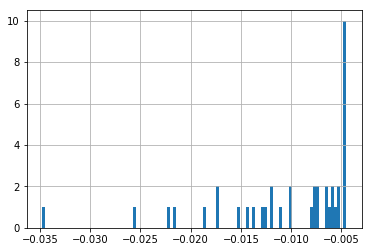

In [42]:
column = 'stop_loss_pct'
result.sort_values(by=[column])[column].hist(bins=100)

In [43]:
column = 'stop_loss_pct'
bins = np.arange(50) * 0.0025 - 0.10
result['binned'] = pd.cut(result[column], bins)
result.groupby(result['binned']).size()

binned
(-0.1, -0.0975]       0
(-0.0975, -0.095]     0
(-0.095, -0.0925]     0
(-0.0925, -0.09]      0
(-0.09, -0.0875]      0
(-0.0875, -0.085]     0
(-0.085, -0.0825]     0
(-0.0825, -0.08]      0
(-0.08, -0.0775]      0
(-0.0775, -0.075]     0
(-0.075, -0.0725]     0
(-0.0725, -0.07]      0
(-0.07, -0.0675]      0
(-0.0675, -0.065]     0
(-0.065, -0.0625]     0
(-0.0625, -0.06]      0
(-0.06, -0.0575]      0
(-0.0575, -0.055]     0
(-0.055, -0.0525]     0
(-0.0525, -0.05]      0
(-0.05, -0.0475]      0
(-0.0475, -0.045]     0
(-0.045, -0.0425]     0
(-0.0425, -0.04]      0
(-0.04, -0.0375]      0
(-0.0375, -0.035]     0
(-0.035, -0.0325]     1
(-0.0325, -0.03]      0
(-0.03, -0.0275]      0
(-0.0275, -0.025]     1
(-0.025, -0.0225]     0
(-0.0225, -0.02]      2
(-0.02, -0.0175]      1
(-0.0175, -0.015]     3
(-0.015, -0.0125]     3
(-0.0125, -0.01]      6
(-0.01, -0.0075]      3
(-0.0075, -0.005]    10
(-0.005, -0.0025]    10
(-0.0025, 0.0]        0
(0.0, 0.0025]         0
(0.0025, 

In [44]:
result[result.rr_ratio >= 2]['stop_loss_triggered'].value_counts()

False    11
True      8
Name: stop_loss_triggered, dtype: int64

In [45]:
column = 'stop_loss_pct'
result.sort_values(by=[column])

,side,entry_price,stop_loss,stop_loss_pct,high_water_mark,low_water_mark,max_abs_return,min_abs_return,stop_loss_triggered,rr_ratio,binned
timestamp,,,,,,,,,,,
2019-07-01 15:00:00+00:00,BUY,10308.7,9950.0,-0.034796,10658.5,9950.0,0.033933,-0.034796,True,0.975188,"(-0.035, -0.0325]"
2019-06-27 09:00:00+00:00,BUY,11642.7,11344.0,-0.025656,12177.5,11344.0,0.045934,-0.025656,True,1.790425,"(-0.0275, -0.025]"
2019-07-13 19:00:00+00:00,BUY,11194.4,10945.0,-0.022279,11182.5,10945.0,-0.001063,-0.022279,True,-0.047715,"(-0.0225, -0.02]"
2019-06-04 00:00:00+00:00,BUY,7889.9,7718.5,-0.021724,8020.0,7718.5,0.016489,-0.021724,True,0.759043,"(-0.0225, -0.02]"
2019-07-01 00:00:00+00:00,BUY,10813.6,10613.5,-0.018504,11220.0,10613.5,0.037582,-0.018504,True,2.030985,"(-0.02, -0.0175]"
2019-05-30 16:00:00+00:00,SELL,8956.3,9111.0,-0.017273,8673.5,7944.0,0.113027,0.031576,False,6.543633,"(-0.0175, -0.015]"
2019-06-15 16:00:00+00:00,SELL,8777.4,8929.0,-0.017272,8929.0,8775.0,0.000273,-0.017272,True,0.015831,"(-0.0175, -0.015]"
2019-07-01 13:00:00+00:00,BUY,10622.5,10459.0,-0.015392,10618.5,10459.0,-0.000377,-0.015392,True,-0.024465,"(-0.0175, -0.015]"
2019-07-14 09:00:00+00:00,BUY,10764.1,10610.0,-0.014316,10879.0,10610.0,0.010674,-0.014316,True,0.745620,"(-0.015, -0.0125]"


In [130]:
entry_price=9498.8
stop_loss=9500.0
stop_loss_pct=-0.000126
STOP_LOSS_PCT_FLOOR = 0.0012

In [131]:
# BUYs
stop_loss_adj = entry_price * (1-STOP_LOSS_PCT_FLOOR)
math.floor(stop_loss_adj/0.5) * 0.5

# SELLs
stop_loss_adj = entry_price * (1+STOP_LOSS_PCT_FLOOR)
math.ceil(stop_loss_adj/0.5) * 0.5

In [20]:
get_klines_df('XBTUSD', '5m', startDate=result_subset.index[0].strftime('%Y-%m-%d %H:%M:%S'), endDate=result_subset.index[1].strftime('%Y-%m-%d %H:%M:%S'))

,timestamp,symbol,open,high,low,close,trades,volume,vwap,lastSize,turnover,homeNotional,foreignNotional
0,2018-06-19 12:00:00+00:00,XBTUSD,6731.0,6731.0,6717.5,6718.0,1811,9708767,6724.0452,50.0,144394421230,1443.944212,9708767.0
1,2018-06-19 12:05:00+00:00,XBTUSD,6718.0,6725.5,6717.5,6725.5,1019,5754323,6723.1411,24616.0,85593870084,855.938701,5754323.0
2,2018-06-19 12:10:00+00:00,XBTUSD,6725.5,6749.0,6725.0,6729.5,2974,17311318,6736.2748,318.0,256989084514,2569.890845,17311318.0
3,2018-06-19 12:15:00+00:00,XBTUSD,6729.5,6729.5,6710.0,6715.0,2416,14670740,6718.6240,950.0,218370601796,2183.706018,14670740.0
4,2018-06-19 12:20:00+00:00,XBTUSD,6715.0,6720.5,6714.5,6720.5,867,5879875,6716.8189,122086.0,87541833824,875.418338,5879875.0
5,2018-06-19 12:25:00+00:00,XBTUSD,6720.5,6720.5,6715.0,6720.0,1039,5487678,6717.7213,5.0,81693894168,816.938942,5487678.0
6,2018-06-19 12:30:00+00:00,XBTUSD,6720.0,6727.5,6719.5,6727.5,1022,4439715,6723.1411,51.0,66039703894,660.397039,4439715.0
7,2018-06-19 12:35:00+00:00,XBTUSD,6727.5,6728.5,6723.5,6725.5,934,3800265,6725.8542,1.0,56505526138,565.055261,3800265.0
8,2018-06-19 12:40:00+00:00,XBTUSD,6725.5,6744.0,6725.0,6733.5,2556,13940585,6734.4602,1.0,207009299040,2070.092990,13940585.0
9,2018-06-19 12:45:00+00:00,XBTUSD,6733.5,6734.0,6724.0,6728.0,1261,5262877,6729.0223,2.0,78215547127,782.155471,5262877.0


In [2]:
client = bitmex.bitmex(test=False, api_key=api_key, api_secret=api_secret)

NameError: name 'bitmex' is not defined

In [21]:
client.Trade.Trade_getBucketed(symbol='XBTUSD', binSize='5m', startTime=datetime.strptime('2019-05-13 03:00:00', '%Y-%m-%d %H:%M:%S'), endTime=datetime.strptime('2019-05-13 11:00:00', '%Y-%m-%d %H:%M:%S'), count=5).result()

([{'timestamp': datetime.datetime(2019, 5, 13, 3, 0, tzinfo=tzutc()),
   'symbol': 'XBTUSD',
   'open': 7035.0,
   'high': 7047.0,
   'low': 7035.0,
   'close': 7044.5,
   'trades': 2055,
   'volume': 10490419,
   'vwap': 7043.2455,
   'lastSize': 1000,
   'turnover': 148943591797,
   'homeNotional': 1489.435917969999,
   'foreignNotional': 10490419.0},
  {'timestamp': datetime.datetime(2019, 5, 13, 3, 5, tzinfo=tzutc()),
   'symbol': 'XBTUSD',
   'open': 7044.5,
   'high': 7070.0,
   'low': 7031.5,
   'close': 7057.5,
   'trades': 4394,
   'volume': 18444734,
   'vwap': 7053.181,
   'lastSize': 250,
   'turnover': 261512720319,
   'homeNotional': 2615.12720319,
   'foreignNotional': 18444734.0},
  {'timestamp': datetime.datetime(2019, 5, 13, 3, 10, tzinfo=tzutc()),
   'symbol': 'XBTUSD',
   'open': 7057.5,
   'high': 7071.0,
   'low': 7054.5,
   'close': 7071.0,
   'trades': 2467,
   'volume': 10287383,
   'vwap': 7064.6415,
   'lastSize': 57,
   'turnover': 145626395895,
   'homeNoti

In [18]:
result_subset

NameError: name 'result_subset' is not defined

In [141]:
rr_ratio = [12,10,9,8,7,6.5,6,5.5,5,4.5,4,3.5,3,2.5,2,1.5,1.0]

In [145]:
12 in rr_ratio

True

In [321]:
TD_binSize = timedelta(hours = 1)
data_df = get_klines_df('XBTUSD', '1h', '2019-07-01 00:00:00')
data_df = data_df.drop(columns=['homeNotional','foreignNotional','turnover','vwap','lastSize'])
data_df = data_df.drop([0], axis=0)    # drop first row, otherwise resample will not work properly
data_df.index = data_df.timestamp     # change RangeIndex to TimestampIndex

data_df['period_high_slow'] = data_df['high'].rolling(19, min_periods=4).max().shift(1)
data_df['period_high_fast'] = data_df['high'].rolling(3, min_periods=3).max().shift(1)

data_df['period_low_slow'] = data_df['low'].rolling(19, min_periods=4).min().shift(1)
data_df['period_low_fast'] = data_df['low'].rolling(3, min_periods=3).min().shift(1)

# assign new columns based on conditions
data_df.loc[data_df.high > data_df.period_high_slow, 'isNewHigh'] = True
data_df.loc[data_df.high <= data_df.period_high_slow, 'isNewHigh'] = False

data_df.loc[data_df.low < data_df.period_low_slow, 'isNewLow'] = True
data_df.loc[data_df.low >= data_df.period_low_slow, 'isNewLow'] = False

In [248]:
for timestamp,row in data_df.iterrows():
    print(data_df.loc[timestamp-(3*TD_binSize):timestamp]['isNewLow'].value_counts())
    print(True in data_df.loc[timestamp-(3*TD_binSize):timestamp]['isNewLow'].value_counts().index)

Series([], Name: isNewLow, dtype: int64)
False
Series([], Name: isNewLow, dtype: int64)
False
Series([], Name: isNewLow, dtype: int64)
False
Series([], Name: isNewLow, dtype: int64)
False
False    1
Name: isNewLow, dtype: int64
False
False    2
Name: isNewLow, dtype: int64
False
False    3
Name: isNewLow, dtype: int64
False
False    4
Name: isNewLow, dtype: int64
False
False    4
Name: isNewLow, dtype: int64
False
False    4
Name: isNewLow, dtype: int64
False
False    4
Name: isNewLow, dtype: int64
False
False    4
Name: isNewLow, dtype: int64
False
False    3
True     1
Name: isNewLow, dtype: int64
True
False    3
True     1
Name: isNewLow, dtype: int64
True
True     2
False    2
Name: isNewLow, dtype: int64
True
True     3
False    1
Name: isNewLow, dtype: int64
True
True     2
False    2
Name: isNewLow, dtype: int64
True
True     2
False    2
Name: isNewLow, dtype: int64
True
False    3
True     1
Name: isNewLow, dtype: int64
True
False    4
Name: isNewLow, dtype: int64
False
False 

In [175]:
data_df.index[0]

Timestamp('2019-07-01 01:00:00+0000', tz='tzutc()')

In [329]:
data_df.loc[data_df.tail(4)['low'].idxmin()]

TypeError: Cannot index by location index with a non-integer key

In [47]:
result.items()

<generator object DataFrame.iteritems at 0x7f4f02828930>

In [356]:
tx_df = pd.DataFrame(columns=['timestamp', 'side', 'entry_price', 'stop_loss'])
len(tx_df)

0